<a href="https://colab.research.google.com/github/VladimirBoshnjakovski/explainable-ai-thesis-code/blob/main/03_whitebox_decision_tree.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# STEP 1: Install required libraries (if not already present)
!pip install pandas scikit-learn matplotlib seaborn

# Load core libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Load dataset from correct public URL
url = "https://raw.githubusercontent.com/nmiuddin/UCI-Heart-Disease-Dataset/master/data/heart-disease-UCI.csv"
df = pd.read_csv(url)

# Preview the data
print(f"Shape: {df.shape}")
df.head()


Shape: (303, 14)


,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
0,63,1,3,145,233,1,0,150,0,2.3,0,0,1,1
1,37,1,2,130,250,0,1,187,0,3.5,0,0,2,1
2,41,0,1,130,204,0,0,172,0,1.4,2,0,2,1
3,56,1,1,120,236,0,1,178,0,0.8,2,0,2,1
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1


In [ ]:
df.rename(columns={
    'age': 'Age',
    'sex': 'Sex (0=Female, 1=Male)',
    'cp': 'Chest Pain Type (4 Categories)',
    'trestbps': 'Resting Blood Pressure (mm Hg)',
    'chol': 'Serum Cholesterol (mg/dL)',
    'fbs': 'Fasting Blood Sugar > 120 mg/dL (1=Yes)',
    'restecg': 'Resting Electrocardiographic Results',
    'thalach': 'Maximum Heart Rate Achieved',
    'exang': 'Exercise-Induced Angina (1=Yes)',
    'oldpeak': 'ST Depression Induced by Exercise',
    'slope': 'Slope of the Peak Exercise ST Segment',
    'ca': 'Number of Major Vessels Colored by Fluoroscopy',
    'thal': 'Type of Thalassemia',
    'target': 'Presence of Heart Disease (1=Yes)'
}, inplace=True)


In [ ]:
# Remove rows where the number of vessels equals 4
df = df[df['Number of Major Vessels Colored by Fluoroscopy'] != 4]

# Convert relevant columns to 'category' dtype
categorical_columns = [
    'Sex (0=Female, 1=Male)',
    'Chest Pain Type (4 Categories)',
    'Fasting Blood Sugar > 120 mg/dL (1=Yes)',
    'Resting Electrocardiographic Results',
    'Exercise-Induced Angina (1=Yes)',
    'Slope of the Peak Exercise ST Segment',
    'Number of Major Vessels Colored by Fluoroscopy',
    'Type of Thalassemia',
    'Presence of Heart Disease (1=Yes)'
]

for col in categorical_columns:
    df[col] = df[col].astype('category')

# Print all columns and their data types
for col in df.columns:
    dtype = df[col].dtype
    cat_flag = " (categorical)" if dtype.name == 'category' else ""
    print(f"{col}: {dtype}{cat_flag}")



Age: int64
Sex (0=Female, 1=Male): category (categorical)
Chest Pain Type (4 Categories): category (categorical)
Resting Blood Pressure (mm Hg): int64
Serum Cholesterol (mg/dL): int64
Fasting Blood Sugar > 120 mg/dL (1=Yes): category (categorical)
Resting Electrocardiographic Results: category (categorical)
Maximum Heart Rate Achieved: int64
Exercise-Induced Angina (1=Yes): category (categorical)
ST Depression Induced by Exercise: float64
Slope of the Peak Exercise ST Segment: category (categorical)
Number of Major Vessels Colored by Fluoroscopy: category (categorical)
Type of Thalassemia: category (categorical)
Presence of Heart Disease (1=Yes): category (categorical)


In [ ]:
# Manually hot-wire the categorical variables into human-readable dummy columns

# Sex (0 = Female, 1 = Male)
df['Sex: Female'] = df['Sex (0=Female, 1=Male)'].apply(lambda x: 1 if x == 0 else 0)
df['Sex: Male'] = df['Sex (0=Female, 1=Male)'].apply(lambda x: 1 if x == 1 else 0)

# Chest Pain Type: 0 = Typical Angina, 1 = Atypical Angina, 2 = Non-anginal pain, 3 = Asymptomatic
df['Chest Pain: Typical Angina'] = df['Chest Pain Type (4 Categories)'].apply(lambda x: 1 if x == 0 else 0)
df['Chest Pain: Atypical Angina'] = df['Chest Pain Type (4 Categories)'].apply(lambda x: 1 if x == 1 else 0)
df['Chest Pain: Non-Anginal'] = df['Chest Pain Type (4 Categories)'].apply(lambda x: 1 if x == 2 else 0)
df['Chest Pain: Asymptomatic'] = df['Chest Pain Type (4 Categories)'].apply(lambda x: 1 if x == 3 else 0)

# Fasting Blood Sugar > 120 mg/dL (1 = Yes, 0 = No)
df['Fasting Blood Sugar: Yes'] = df['Fasting Blood Sugar > 120 mg/dL (1=Yes)'].apply(lambda x: 1 if x == 1 else 0)
df['Fasting Blood Sugar: No'] = df['Fasting Blood Sugar > 120 mg/dL (1=Yes)'].apply(lambda x: 1 if x == 0 else 0)

# Resting ECG: 0 = Normal, 1 = ST Abnormality, 2 = Left Ventricular Hypertrophy
df['Resting ECG: Normal'] = df['Resting Electrocardiographic Results'].apply(lambda x: 1 if x == 0 else 0)
df['Resting ECG: ST Abnormality'] = df['Resting Electrocardiographic Results'].apply(lambda x: 1 if x == 1 else 0)
df['Resting ECG: Left Ventricular Hypertrophy'] = df['Resting Electrocardiographic Results'].apply(lambda x: 1 if x == 2 else 0)

# Exercise-Induced Angina (1 = Yes, 0 = No)
df['Exercise-Induced Angina: Yes'] = df['Exercise-Induced Angina (1=Yes)'].apply(lambda x: 1 if x == 1 else 0)
df['Exercise-Induced Angina: No'] = df['Exercise-Induced Angina (1=Yes)'].apply(lambda x: 1 if x == 0 else 0)

# Slope of the Peak Exercise ST Segment: 0 = Upsloping, 1 = Flat, 2 = Downsloping
df['ST Slope: Upsloping'] = df['Slope of the Peak Exercise ST Segment'].apply(lambda x: 1 if x == 0 else 0)
df['ST Slope: Flat'] = df['Slope of the Peak Exercise ST Segment'].apply(lambda x: 1 if x == 1 else 0)
df['ST Slope: Downsloping'] = df['Slope of the Peak Exercise ST Segment'].apply(lambda x: 1 if x == 2 else 0)

# Thalassemia Type: 0 = Normal, 1 = Fixed Defect, 2 = Reversible Defect
df['Thalassemia: Normal'] = df['Type of Thalassemia'].apply(lambda x: 1 if x == 0 else 0)
df['Thalassemia: Fixed Defect'] = df['Type of Thalassemia'].apply(lambda x: 1 if x == 1 else 0)
df['Thalassemia: Reversible Defect'] = df['Type of Thalassemia'].apply(lambda x: 1 if x == 2 else 0)

# Number of Major Vessels Colored by Fluoroscopy: 0 to 3 (value 4 already removed)
df['Fluoroscopy: 0 Vessels'] = df['Number of Major Vessels Colored by Fluoroscopy'].apply(lambda x: 1 if x == 0 else 0)
df['Fluoroscopy: 1 Vessel'] = df['Number of Major Vessels Colored by Fluoroscopy'].apply(lambda x: 1 if x == 1 else 0)
df['Fluoroscopy: 2 Vessels'] = df['Number of Major Vessels Colored by Fluoroscopy'].apply(lambda x: 1 if x == 2 else 0)
df['Fluoroscopy: 3 Vessels'] = df['Number of Major Vessels Colored by Fluoroscopy'].apply(lambda x: 1 if x == 3 else 0)

# Drop original categorical columns
df.drop(columns=[
    'Sex (0=Female, 1=Male)',
    'Chest Pain Type (4 Categories)',
    'Fasting Blood Sugar > 120 mg/dL (1=Yes)',
    'Resting Electrocardiographic Results',
    'Exercise-Induced Angina (1=Yes)',
    'Slope of the Peak Exercise ST Segment',
    'Type of Thalassemia',
    'Number of Major Vessels Colored by Fluoroscopy'
], inplace=True)

# Convert all 0/1 dummy variables to category dtype (optional)
dummy_cols = [col for col in df.columns if set(df[col].unique()) <= {0, 1}]
df[dummy_cols] = df[dummy_cols].astype('category')

# Preview the updated DataFrame
df.head(10)


,Age,Resting Blood Pressure (mm Hg),Serum Cholesterol (mg/dL),Maximum Heart Rate Achieved,ST Depression Induced by Exercise,Presence of Heart Disease (1=Yes),Sex: Female,Sex: Male,Chest Pain: Typical Angina,Chest Pain: Atypical Angina,...,ST Slope: Upsloping,ST Slope: Flat,ST Slope: Downsloping,Thalassemia: Normal,Thalassemia: Fixed Defect,Thalassemia: Reversible Defect,Fluoroscopy: 0 Vessels,Fluoroscopy: 1 Vessel,Fluoroscopy: 2 Vessels,Fluoroscopy: 3 Vessels
0,63,145,233,150,2.3,1,0,1,0,0,...,1,0,0,0,1,0,1,0,0,0
1,37,130,250,187,3.5,1,0,1,0,0,...,1,0,0,0,0,1,1,0,0,0
2,41,130,204,172,1.4,1,1,0,0,1,...,0,0,1,0,0,1,1,0,0,0
3,56,120,236,178,0.8,1,0,1,0,1,...,0,0,1,0,0,1,1,0,0,0
4,57,120,354,163,0.6,1,1,0,1,0,...,0,0,1,0,0,1,1,0,0,0
5,57,140,192,148,0.4,1,0,1,1,0,...,0,1,0,0,1,0,1,0,0,0
6,56,140,294,153,1.3,1,1,0,0,1,...,0,1,0,0,0,1,1,0,0,0
7,44,120,263,173,0.0,1,0,1,0,1,...,0,0,1,0,0,0,1,0,0,0
8,52,172,199,162,0.5,1,0,1,0,0,...,0,0,1,0,0,0,1,0,0,0
9,57,150,168,174,1.6,1,0,1,0,0,...,0,0,1,0,0,1,1,0,0,0


In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

# Step 1: Split data into features (X) and target (y)
X = df.drop(columns='Presence of Heart Disease (1=Yes)')
y = df['Presence of Heart Disease (1=Yes)']

# Step 2: Train-test split (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train an unrestricted, deeper decision tree
dt_model = DecisionTreeClassifier(
    random_state=42,
    max_depth=None,              # unlimited depth
    min_samples_split=2,         # smallest possible split
    min_samples_leaf=1,          # smallest leaf size
    max_features=None            # consider all features at every split
)
dt_model.fit(X_train, y_train)

# Predictions
y_pred = dt_model.predict(X_test)


# Step 5: Evaluate the model
print("Accuracy:", accuracy_score(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Accuracy: 0.8

Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.78      0.75        23
           1       0.86      0.81      0.83        37

    accuracy                           0.80        60
   macro avg       0.79      0.80      0.79        60
weighted avg       0.80      0.80      0.80        60

Confusion Matrix:
 [[18  5]
 [ 7 30]]


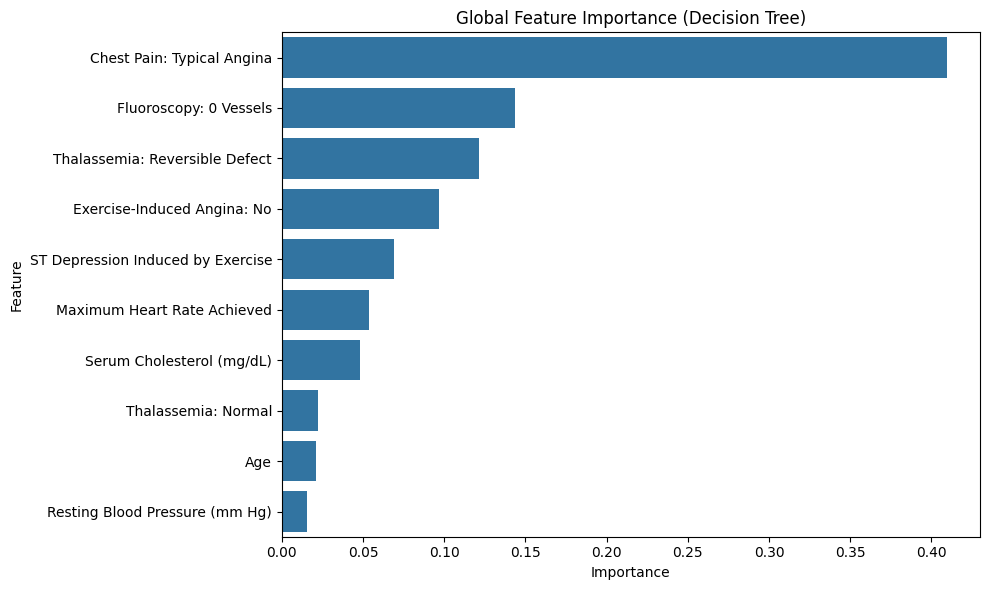

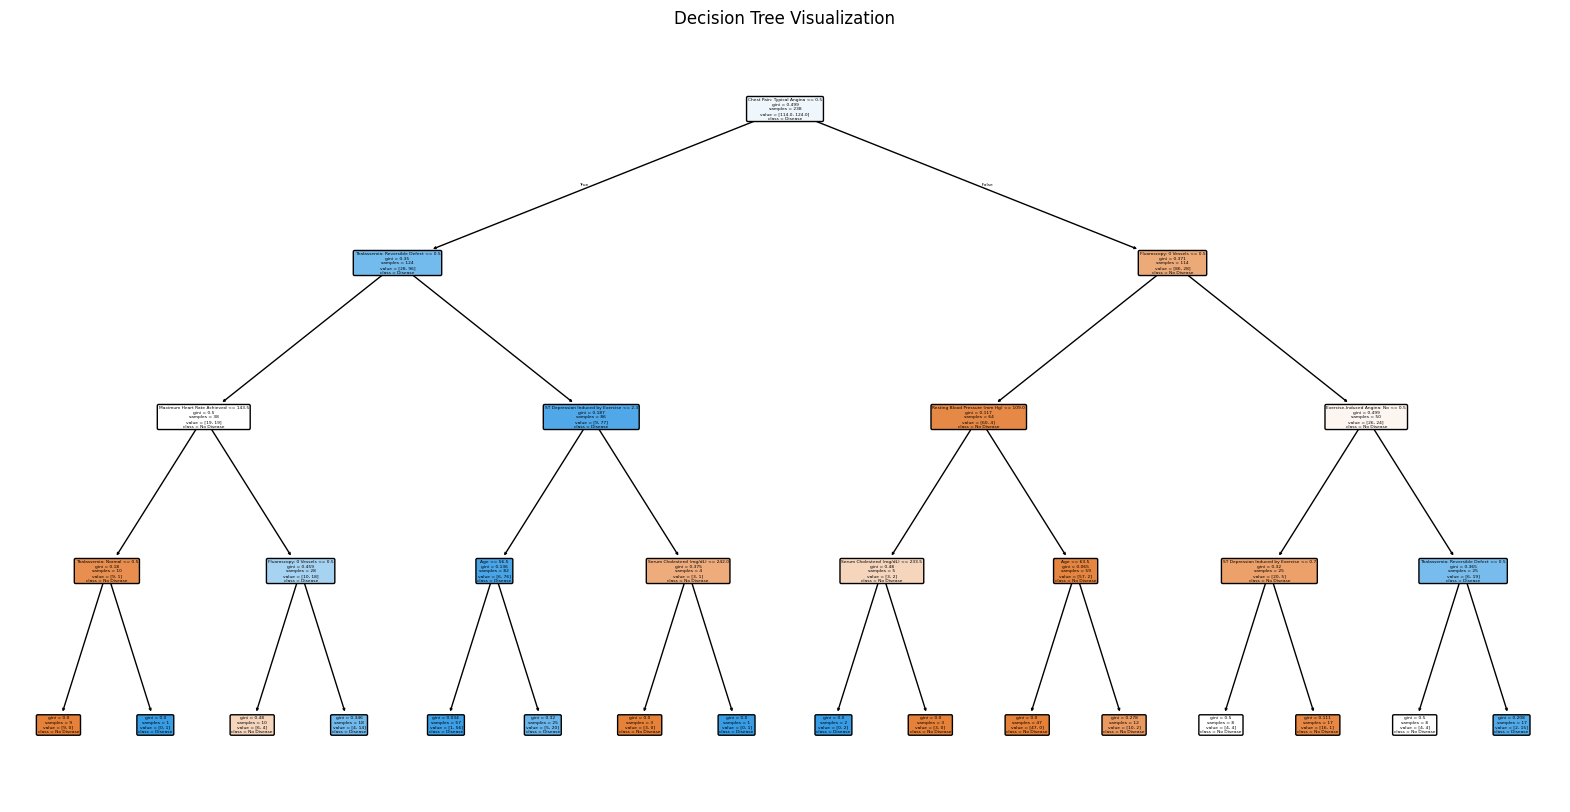

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Split the data
X = df.drop(columns='Presence of Heart Disease (1=Yes)')
y = df['Presence of Heart Disease (1=Yes)']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Decision Tree with a manageable depth for interpretability
model = DecisionTreeClassifier(max_depth=4, random_state=42)
model.fit(X_train, y_train)

# --- GLOBAL INTERPRETATION ---
importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({'Feature': features, 'Importance': importances})
importance_df = importance_df[importance_df['Importance'] > 0].sort_values(by='Importance', ascending=False)

# Barplot of feature importances
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=importance_df)
plt.title("Global Feature Importance (Decision Tree)")
plt.tight_layout()
plt.show()

# Visualize the tree structure
plt.figure(figsize=(20, 10))
plot_tree(model, feature_names=X.columns, class_names=['No Disease', 'Disease'], filled=True, rounded=True)
plt.title("Decision Tree Visualization")
plt.show()



In [ ]:
# Loop through test set until we find one with both positive and negative contributions
for i in range(len(X_test)):
    instance = X_test.iloc[[i]]
    node_indicator = dt_model.decision_path(instance)
    nodes = node_indicator.indices
    feature_contributions = []

    for node_index in nodes[:-1]:  # exclude leaf
        feature_index = dt_model.tree_.feature[node_index]
        if feature_index == -2:
            continue  # skip leaf
        threshold = dt_model.tree_.threshold[node_index]
        if instance.iloc[0, feature_index] <= threshold:
            next_node = dt_model.tree_.children_left[node_index]
        else:
            next_node = dt_model.tree_.children_right[node_index]

        # Use predicted probability of class 1
        current_proba = dt_model.tree_.value[node_index][0][1] / dt_model.tree_.value[node_index][0].sum()
        next_proba = dt_model.tree_.value[next_node][0][1] / dt_model.tree_.value[next_node][0].sum()
        contrib = next_proba - current_proba

        feature_contributions.append((X.columns[feature_index], round(contrib, 4)))

    contrib_vals = [x[1] for x in feature_contributions]
    if any(c > 0 for c in contrib_vals) and any(c < 0 for c in contrib_vals):
        local_df = pd.DataFrame(feature_contributions, columns=["Feature", "Δ Probability for Class 1"])

        # Final predicted probability at the leaf node
        final_node = nodes[-1]
        final_proba = dt_model.tree_.value[final_node][0][1] / dt_model.tree_.value[final_node][0].sum()

        print(f"\nInstance {i} has both positive and negative contributions:")
        print(local_df)
        print(f"\n✅ Final predicted probability for Class 1: {round(final_proba, 4)}")
        break



Instance 1 has both positive and negative contributions:
                             Feature  Δ Probability for Class 1
0         Chest Pain: Typical Angina                    -0.2754
1             Fluoroscopy: 0 Vessels                     0.2344
2       Exercise-Induced Angina: Yes                    -0.2800
3  ST Depression Induced by Exercise                    -0.1412
4     Resting Blood Pressure (mm Hg)                    -0.0588

✅ Final predicted probability for Class 1: 0.0


In [ ]:
final_node = nodes[-1]
final_proba = dt_model.tree_.value[final_node][0][1] / dt_model.tree_.value[final_node][0].sum()


In [ ]:
# Step 6: Compute average probability for Class 1 at the root node
root_node = 0
class_counts = dt_model.tree_.value[root_node][0]  # [class_0_count, class_1_count]
total_samples = class_counts.sum()
avg_class_1_proba = class_counts[1] / total_samples

print(f"\n✅ Average probability for Class 1 at the root node: {round(avg_class_1_proba, 4)}")


✅ Average probability for Class 1 at the root node: 0.521
